# Soccer - PPO

---


### 1. Setup Environment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.distributions as distributions
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from collections import deque
import datetime
import pytz

import numpy as np
import matplotlib.pyplot as plt

def get_time(format):
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return pst_now.strftime(format)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Load Unity Soccer Game

Environments contain **_brains_** which are responsible for deciding the actions of their agents. Here we obtain separate brains for the striker and goalie agents and examine the state and action spaces.

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="Soccer_Linux_NoVis/Soccer.x86_64.app", seed=1)
#env = UnityEnvironment(file_name="Soccer.app", seed=0)

# set the goalie brain
g_brain_name = env.brain_names[0]
g_brain = env.brains[g_brain_name]

# set the striker brain
s_brain_name = env.brain_names[1]
s_brain = env.brains[s_brain_name]

# reset the environment
env_info = env.reset(train_mode=True)

# number of agents 
num_g_agents = len(env_info[g_brain_name].agents)
print('Number of goalie agents:', num_g_agents)
num_s_agents = len(env_info[s_brain_name].agents)
print('Number of striker agents:', num_s_agents)

# number of actions
g_action_size = g_brain.vector_action_space_size
print('Number of goalie actions:', g_action_size)
s_action_size = s_brain.vector_action_space_size
print('Number of striker actions:', s_action_size)

# examine the state space 
g_states = env_info[g_brain_name].vector_observations
g_state_size = g_states.shape[1]
print('There are {} goalie agents. Each receives a state with length: {}'.format(g_states.shape[0], g_state_size))
s_states = env_info[s_brain_name].vector_observations
s_state_size = s_states.shape[1]
print('There are {} striker agents. Each receives a state with length: {}'.format(s_states.shape[0], s_state_size))


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


Number of goalie agents: 2
Number of striker agents: 2
Number of goalie actions: 4
Number of striker actions: 6
There are 2 goalie agents. Each receives a state with length: 336
There are 2 striker agents. Each receives a state with length: 336


### 3. Setup Actor and Critic Networks

The <strong>actor</strong> receives his own state space and outputs an action, the log probability of that action (to be used later in calculating the advantage ratio) and the entropy of the probability distribution. Higher entropy indicates more uncertainty in the probabilities. For example, when the probability of the goalie choosing 1 of the 4 possible actions is roughly equal (25% each), this would be maximum entropy. When one of those actions has 100% probability and the other 3 actions have 0% probability, the agent is absolutely certain and entropy will be zero. 

We use <strong>entropy</strong> as noise in the loss function to force the agent to try more random actions early on and not get fixated on a solution which is not optimal in the long run (stuck in a local minima.)

The <strong>critic</strong> receives the combined state space of all 4 agents on the field and outputs the expected average value (total reward) for an action taken given that state. We will use this value to compare to the actual total reward received from an actor's action. This will tell us how much better the chosen action (the advantage) is compared to the average likely reward.

A note on the distributions function:

It is not possible to have the actor simply output a softmax distribution of action probabilities and then choose an action off a random sampling of those probabilities. Neural networks cannot directly backpropagate through random samples. PyTorch and Tensorflow offer a <a href="https://pytorch.org/docs/stable/distributions.html">distribution function</a> to solve this that makes the action selection differentiable. The actor passes the softmax output through this distribution function to select the action and then backpropagation can occur.

In [3]:
def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

class Actor(nn.Module):

    def __init__(self, state_size, action_size, hidden_0, hidden_1):
        super(Actor, self).__init__()
               
        self.fc1 = layer_init(nn.Linear(state_size, hidden_0))
        self.fc2 = layer_init(nn.Linear(hidden_0, hidden_1))
        self.fc3 = layer_init(nn.Linear(hidden_1, action_size))
        
    def forward(self, x, action=None):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        dist = distributions.Categorical(x)

        if action is None:
            action = dist.sample()
        
        log_prob = dist.log_prob(action)

        return action, log_prob, dist.entropy()
    
class Critic(nn.Module):

    def __init__(self, state_size, hidden_0, hidden_1):
        super(Critic, self).__init__()
               
        self.fc1 = layer_init(nn.Linear(state_size*4, hidden_0))
        self.fc2 = layer_init(nn.Linear(hidden_0, hidden_1))
        self.fc3 = layer_init(nn.Linear(hidden_1, 1))

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 4. Policy Improvement Function

The learning process takes the experiences from the agents playing one full soccer game. This is either play until a goal was scored or 600 time steps passed and the game was terminated.

In [4]:
def learn(epochs, batch_size, actor, critic, optimizer, old_probs, all_states, states, actions, rewards, discount, epsilon, beta):

    '''
    Calculate the total reward earned for each time step. This is the actual reward earned at that time step,
    plus all the discounted future rewards earned after that time step to the end of the game.
    '''
    discount = discount**np.arange(len(rewards))
    rewards = rewards * discount
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
     # setup torch tensors
    states = torch.tensor(states).float().to(device)
    all_states = torch.stack(all_states)
    all_states = all_states.view(-1, g_state_size*4)
    actions = torch.tensor(actions).long().to(device).detach()
    old_probs = torch.tensor(old_probs).float().to(device).detach()
    rewards = torch.from_numpy(np.array(rewards_future)).float().to(device).detach()
    
    '''
    For Advantage Actor Critic (A2C) we want the agent to take actions which achieve the greatest reward compared
    to the average expected reward for that state (as estimated by our critic.) We compute the advantage function
    below and normalize it to improve training.
    '''
    values = critic_values(critic, all_states)
    advantages = (rewards - values).detach()
    advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1.0e-10)
    advantages_normalized = torch.tensor(advantages_normalized).float().to(device)

    episode_loss = []
    avg_loss = 0

    '''
    We now will learn from this one game's set of experiences a certain number of times (epochs).
    Within the epoch we take the full set of game experiences and break them into random mini-batches to train on.
    '''
    for _ in range(epochs):
        
        batch = BatchSampler(SubsetRandomSampler(range(states.size(0))), batch_size, drop_last=False)

        for batch_indices in batch:
            batch_indices = torch.tensor(batch_indices).long().to(device)
            sampled_states = states[batch_indices]
            sampled_all_states = all_states[batch_indices]
            sampled_actions = actions[batch_indices]
            sampled_old_probs = old_probs[batch_indices]
            sampled_rewards = rewards[batch_indices]
            sampled_advantages = advantages_normalized[batch_indices]

            # get new probability of each action given the state and latest actor policy
            _, log_probs, entropy = actor(sampled_states, sampled_actions)
    
            # ratio - how much more likely is the new action choice vs. old choice according to our updated actor
            ratio = (log_probs - sampled_old_probs).exp()

            '''
            The clipping function makes sure that we don't update our weights too much when we find a much better 
            choice. Keep it within a set limit so we don't accidentally go off the rails following a false lead.
            This is the heart of Proximal Policy Optimization (PPO). It creates a more stable training environment.
            
            Our policy loss, therefore, is going to be the computed advantage of our action, but clipped if it is
            too big a move.
            '''
            clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
        
            policy_loss = torch.min(ratio*sampled_advantages, clip*sampled_advantages)
            policy_loss = -torch.mean(policy_loss)
        
            '''
            Entropy regularization term steers the new policy towards equal probability of all actions, encouraging
            exploration early on, but decreasing in importance over time. See above explanation under "Setup Actor
            and Critic Networks."
            '''
            entropy = torch.mean(entropy)

            # get predicted future rewards to use in backpropagation to improve the critic's estimates
            values = critic(sampled_all_states) 
            value_loss = F.mse_loss(sampled_rewards, values.view(-1))
            
            '''
            The loss function combines the policy loss with value loss and adds the entropy term. PyTorch will
            backpropagate the respective losses through to each network's parameters and optimize over time.
            '''
            loss = policy_loss + (0.5 * value_loss) - (entropy*beta)
            
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(actor.parameters(), .5)
            optimizer.step()
    
            # some reporting to check performance
            if actor == striker_0_actor:
                episode_loss.append(policy_loss.cpu().detach().numpy().squeeze().item())
                policy_loss_value.append(policy_loss.cpu().detach().numpy().squeeze().item())
                value_loss_value.append(value_loss.cpu().detach().numpy().squeeze().item())
                entropy_value.append(torch.mean(entropy))
        
            if actor == goalie_0_actor:
                episode_loss.append(policy_loss.cpu().detach().numpy().squeeze().item())
                policy_loss_value_g.append(policy_loss.cpu().detach().numpy().squeeze().item())
                value_loss_value_g.append(value_loss.cpu().detach().numpy().squeeze().item())
                entropy_value_g.append(torch.mean(entropy))

    return np.array(episode_loss).mean()


# combine all 4 players' state spaces together for the critic
def combine_states(g_states, s_states):
    s_states = torch.from_numpy(s_states).float().to(device)
    g_states = torch.from_numpy(g_states).float().to(device)
    states_all = torch.cat((s_states, g_states), dim=1)
    states_all = states_all.view(-1, g_state_size*4)
    return states_all

#get an action from the actor for each step of game play (inference/eval only)
def act(actor, state):
    state = torch.from_numpy(state).float().to(device)
    state = state.view(-1, g_state_size)
    actor.eval()
    with torch.no_grad():
        action, log_prob, _ = actor(state)
    actor.train()
    log_prob = log_prob.cpu().detach().numpy().item()
    action = action.cpu().detach().numpy().item()
    return log_prob, action

# get critic values detached from the training process (eval/inference only)
def critic_values(critic, states):
    critic.eval()
    with torch.no_grad():
        values = critic(states).detach().squeeze()
    critic.train()
    return values

### 5. Train The Agents

In [5]:
episodes = 100000       # set to run a long time, will break when max avg return of 110.0 is reached
learning_rate = 8e-5    # shared actor/critic learning rate
discount = .995         # how much to reduce future rewards when calculating the current state's total reward
t_max = 600             # the soccer environment runs until 600 steps, then stops, if no goal is scored first
epochs = 1              # how many times to train off of one game's experiences
batch_size = 32         # how small to make the mini batches of a game's experiences when training

hidden_0 = 256          # first hidden layer size for actor and critic
hidden_1 = 128          # second hidden layer size for actor and critic

epsilon = .1            # how much to clip the advantage function
eps_decay = 1           # how fast to tighten the clipping function
beta = .001             # how much entropy to add to the loss for exploration
beta_decay = .995       # how fast to reduce the added entropy

In [6]:
'''
The soccer environment has a goalie and striker for each of two teams. Here one team is being trained and the
other is taking random actions. If a goal is scored, the team gets 1.1 points. Otherwise, zero points for each team.
Over 100 games, the max possible score for a team is 110 (1.1 * 100). The trained team has been successfully
trained when it scores a goal and wins 100 consecutive games.
'''

# setup actor and critic for goalie and striker
striker_0_actor = Actor(s_state_size, s_action_size, hidden_0, hidden_1).to(device)
striker_0_critic = Critic(s_state_size, hidden_0, hidden_1).to(device)
goalie_0_actor = Actor(g_state_size, g_action_size, hidden_0, hidden_1).to(device)
goalie_0_critic = Critic(g_state_size, hidden_0, hidden_1).to(device)

striker_0_optimizer = optim.Adam(list(striker_0_actor.parameters()) + list(striker_0_critic.parameters()), lr=learning_rate)
goalie_0_optimizer = optim.Adam(list(goalie_0_actor.parameters()) + list(goalie_0_critic.parameters()), lr=learning_rate)

# some reporting to track losses and keep a 100 game rolling average of the trained team's score.
team_0_scores = deque(maxlen=100)
team_0_score = 0
rolling_average = []
policy_loss_value = []
value_loss_value = []
entropy_value = []
policy_loss_value_g = []
value_loss_value_g = []
entropy_value_g = []

print ("***STARTED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

for e in range(episodes):                  
    
    all_state_list = []
    s_0_state_list = []
    g_0_state_list = []
    s_0_reward_list = []
    s_0_prob_list = []
    s_0_action_list = []
    g_0_reward_list = []
    g_0_prob_list = []
    g_0_action_list = []

    env_info = env.reset(train_mode=True)                     
    g_states = env_info[g_brain_name].vector_observations  
    s_states = env_info[s_brain_name].vector_observations  
    
    g_scores = np.zeros(num_g_agents)                      
    s_scores = np.zeros(num_s_agents)           

    for i in range(t_max):
        
        # combine all 4 agents' state spaces together
        states_all = combine_states(g_states, s_states)
        
        # select actions and send to environment (best teams trained)
        g0_prob, g0_action = act(goalie_0_actor, g_states[0])
        s0_prob, s0_action = act(striker_0_actor, s_states[0])
        g_actions = np.array([g0_action, np.random.choice(g_action_size)])
        s_actions = np.array([s0_action, np.random.choice(s_action_size)])

        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))
        env_info = env.step(actions)              
        
        # get next states
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations

        # get reward and store experience (s,a,r,p) in lists for each striker and goalie
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        all_state_list.append(states_all)
        
        s_0_state_list.append(s_states[0])
        g_0_state_list.append(g_states[0])
        s_0_reward_list.append(s_rewards[0])
        s_0_prob_list.append(s0_prob)
        s_0_action_list.append(s0_action)
        g_0_reward_list.append(g_rewards[0])
        g_0_prob_list.append(g0_prob)
        g_0_action_list.append(g0_action)
        
        #update scores
        g_scores += g_rewards
        s_scores += s_rewards
        
        # check if episode finished
        done = np.any(env_info[g_brain_name].local_done)  

        # exit loop if episode finished
        if done:                                           
            break

        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
        
    # calculate scores and running team lead
    team_0_score = g_scores[0] + s_scores[0]
    team_0_scores.append(team_0_score)
    rolling_average.append(np.sum(team_0_scores))
                
    # agents learn
    striker_loss = learn(epochs, batch_size, striker_0_actor, striker_0_critic, striker_0_optimizer, s_0_prob_list, all_state_list, s_0_state_list, s_0_action_list, s_0_reward_list, discount, epsilon, beta)
    goalie_loss = learn(epochs, batch_size, goalie_0_actor, goalie_0_critic, goalie_0_optimizer, g_0_prob_list, all_state_list, g_0_state_list, g_0_action_list, g_0_reward_list, discount, epsilon, beta)

    # tighten clipping and reduce exploration over time
    epsilon *= eps_decay                
    beta *= beta_decay
    
    print('Episode {}:\tSteps: {}\tTeam Score: {:.1f} \tAvg 100 Games: {:.1f}\tScores (G|S): {:.2f} | {:.2f}'.format(
                        e+1, i+1, team_0_score, np.sum(team_0_scores), np.sum(g_scores[0]), np.sum(s_scores[0])))

    if np.sum(team_0_scores) >= 110.0:
        print ("***FINISHED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
        print('Training complete!')
        break

***STARTED TRAINING AT 2018-12-10--10:13:18 
Episode 1:	Steps: 520	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.97 | 0.13
Episode 2:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 3:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 4:	Steps: 531	Team Score: -1.1 	Avg 100 Games: 0.0	Scores (G|S): -0.12 | -0.99
Episode 5:	Steps: 367	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.71 | 0.39
Episode 6:	Steps: 286	Team Score: -1.1 	Avg 100 Games: 0.0	Scores (G|S): -0.52 | -0.58
Episode 7:	Steps: 165	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.38 | 0.72
Episode 8:	Steps: 55	Team Score: -1.1 	Avg 100 Games: 0.0	Scores (G|S): -0.91 | -0.19
Episode 9:	Steps: 544	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 1.01 | 0.09
Episode 10:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 11:	Steps: 248	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.51 | 0.59
Episode 12:	Steps:

Episode 96:	Steps: 442	Team Score: -1.1 	Avg 100 Games: -0.0	Scores (G|S): -0.26 | -0.84
Episode 97:	Steps: 162	Team Score: -1.1 	Avg 100 Games: -1.1	Scores (G|S): -0.73 | -0.37
Episode 98:	Steps: 276	Team Score: -1.1 	Avg 100 Games: -2.2	Scores (G|S): -0.54 | -0.56
Episode 99:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -2.2	Scores (G|S): 1.00 | -1.00
Episode 100:	Steps: 542	Team Score: -1.1 	Avg 100 Games: -3.3	Scores (G|S): -0.10 | -1.00
Episode 101:	Steps: 127	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.79 | -0.31
Episode 102:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -5.5	Scores (G|S): 1.00 | -1.00
Episode 103:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -5.5	Scores (G|S): 1.00 | -1.00
Episode 104:	Steps: 62	Team Score: 1.1 	Avg 100 Games: -3.3	Scores (G|S): 0.20 | 0.90
Episode 105:	Steps: 60	Team Score: 1.1 	Avg 100 Games: -3.3	Scores (G|S): 0.20 | 0.90
Episode 106:	Steps: 42	Team Score: -1.1 	Avg 100 Games: -3.3	Scores (G|S): -0.93 | -0.17
Episode 107:	Steps: 58	Team S

Episode 190:	Steps: 202	Team Score: 1.1 	Avg 100 Games: 14.3	Scores (G|S): 0.44 | 0.66
Episode 191:	Steps: 90	Team Score: 1.1 	Avg 100 Games: 14.3	Scores (G|S): 0.25 | 0.85
Episode 192:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 15.4	Scores (G|S): 1.00 | -1.00
Episode 193:	Steps: 312	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.48 | -0.62
Episode 194:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.14 | 0.96
Episode 195:	Steps: 524	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.97 | 0.13
Episode 196:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.15 | 0.95
Episode 197:	Steps: 540	Team Score: -1.1 	Avg 100 Games: 18.7	Scores (G|S): -0.10 | -1.00
Episode 198:	Steps: 443	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.84 | 0.26
Episode 199:	Steps: 197	Team Score: -1.1 	Avg 100 Games: 19.8	Scores (G|S): -0.67 | -0.43
Episode 200:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 20.9	Scores (G|S): 1.00 | -1.00
Episode 201:	Steps: 179	Team Score:

Episode 284:	Steps: 317	Team Score: 1.1 	Avg 100 Games: 5.5	Scores (G|S): 0.63 | 0.47
Episode 285:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 5.5	Scores (G|S): 1.00 | -1.00
Episode 286:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 4.4	Scores (G|S): 1.00 | -1.00
Episode 287:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 4.4	Scores (G|S): 1.00 | -1.00
Episode 288:	Steps: 417	Team Score: 1.1 	Avg 100 Games: 4.4	Scores (G|S): 0.80 | 0.31
Episode 289:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 5.5	Scores (G|S): 1.00 | -1.00
Episode 290:	Steps: 397	Team Score: 1.1 	Avg 100 Games: 5.5	Scores (G|S): 0.76 | 0.34
Episode 291:	Steps: 232	Team Score: 1.1 	Avg 100 Games: 5.5	Scores (G|S): 0.49 | 0.61
Episode 292:	Steps: 418	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 0.80 | 0.30
Episode 293:	Steps: 128	Team Score: -1.1 	Avg 100 Games: 6.6	Scores (G|S): -0.79 | -0.31
Episode 294:	Steps: 44	Team Score: -1.1 	Avg 100 Games: 4.4	Scores (G|S): -0.93 | -0.17
Episode 295:	Steps: 439	Team Score: -1.1 	Avg

Episode 378:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 4.4	Scores (G|S): 0.17 | 0.93
Episode 379:	Steps: 505	Team Score: -1.1 	Avg 100 Games: 3.3	Scores (G|S): -0.16 | -0.94
Episode 380:	Steps: 187	Team Score: -1.1 	Avg 100 Games: 2.2	Scores (G|S): -0.69 | -0.41
Episode 381:	Steps: 77	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.87 | -0.23
Episode 382:	Steps: 599	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.00 | -1.10
Episode 383:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 3.3	Scores (G|S): 0.14 | 0.96
Episode 384:	Steps: 87	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.85 | -0.25
Episode 385:	Steps: 319	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.63 | 0.47
Episode 386:	Steps: 102	Team Score: 1.1 	Avg 100 Games: 3.3	Scores (G|S): 0.27 | 0.83
Episode 387:	Steps: 141	Team Score: 1.1 	Avg 100 Games: 4.4	Scores (G|S): 0.33 | 0.77
Episode 388:	Steps: 149	Team Score: 1.1 	Avg 100 Games: 4.4	Scores (G|S): 0.35 | 0.75
Episode 389:	Steps: 70	Team Score: 1.1 	Avg

Episode 472:	Steps: 333	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.66 | 0.45
Episode 473:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.20 | 0.90
Episode 474:	Steps: 408	Team Score: -1.1 	Avg 100 Games: -0.0	Scores (G|S): -0.32 | -0.78
Episode 475:	Steps: 88	Team Score: 1.1 	Avg 100 Games: -0.0	Scores (G|S): 0.25 | 0.85
Episode 476:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.18 | 0.92
Episode 477:	Steps: 210	Team Score: -1.1 	Avg 100 Games: -1.1	Scores (G|S): -0.65 | -0.45
Episode 478:	Steps: 282	Team Score: -1.1 	Avg 100 Games: -3.3	Scores (G|S): -0.53 | -0.57
Episode 479:	Steps: 200	Team Score: -1.1 	Avg 100 Games: -3.3	Scores (G|S): -0.67 | -0.43
Episode 480:	Steps: 87	Team Score: -1.1 	Avg 100 Games: -3.3	Scores (G|S): -0.86 | -0.25
Episode 481:	Steps: 302	Team Score: -1.1 	Avg 100 Games: -3.3	Scores (G|S): -0.50 | -0.60
Episode 482:	Steps: 89	Team Score: -1.1 	Avg 100 Games: -3.3	Scores (G|S): -0.85 | -0.25
Episode 483:	Steps: 326	Team S

Episode 565:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -3.3	Scores (G|S): 1.00 | -1.00
Episode 566:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -2.2	Scores (G|S): 1.00 | -1.00
Episode 567:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -1.1	Scores (G|S): 1.00 | -1.00
Episode 568:	Steps: 125	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.31 | 0.79
Episode 569:	Steps: 153	Team Score: -1.1 	Avg 100 Games: -1.1	Scores (G|S): -0.75 | -0.35
Episode 570:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -0.0	Scores (G|S): 1.00 | -1.00
Episode 571:	Steps: 78	Team Score: -1.1 	Avg 100 Games: -2.2	Scores (G|S): -0.87 | -0.23
Episode 572:	Steps: 532	Team Score: -1.1 	Avg 100 Games: -4.4	Scores (G|S): -0.11 | -0.99
Episode 573:	Steps: 54	Team Score: -1.1 	Avg 100 Games: -6.6	Scores (G|S): -0.91 | -0.19
Episode 574:	Steps: 411	Team Score: 1.1 	Avg 100 Games: -4.4	Scores (G|S): 0.79 | 0.31
Episode 575:	Steps: 507	Team Score: -1.1 	Avg 100 Games: -6.6	Scores (G|S): -0.15 | -0.95
Episode 576:	Steps: 497	Tea

Episode 659:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.23 | 0.88
Episode 660:	Steps: 261	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.54 | 0.57
Episode 661:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 17.6	Scores (G|S): 1.00 | -1.00
Episode 662:	Steps: 231	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.62 | -0.49
Episode 663:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.19 | 0.92
Episode 664:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.16 | 0.94
Episode 665:	Steps: 482	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.90 | 0.20
Episode 666:	Steps: 512	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 0.95 | 0.15
Episode 667:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 19.8	Scores (G|S): 1.00 | -1.00
Episode 668:	Steps: 241	Team Score: -1.1 	Avg 100 Games: 17.6	Scores (G|S): -0.60 | -0.50
Episode 669:	Steps: 169	Team Score: -1.1 	Avg 100 Games: 17.6	Scores (G|S): -0.72 | -0.38
Episode 670:	Steps: 600	Team Score:

Episode 753:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -7.7	Scores (G|S): 1.00 | -1.00
Episode 754:	Steps: 374	Team Score: 1.1 	Avg 100 Games: -7.7	Scores (G|S): 0.72 | 0.38
Episode 755:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -7.7	Scores (G|S): 1.00 | -1.00
Episode 756:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -6.6	Scores (G|S): 1.00 | -1.00
Episode 757:	Steps: 281	Team Score: -1.1 	Avg 100 Games: -7.7	Scores (G|S): -0.53 | -0.57
Episode 758:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -8.8	Scores (G|S): 1.00 | -1.00
Episode 759:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -9.9	Scores (G|S): 1.00 | -1.00
Episode 760:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -11.0	Scores (G|S): 1.00 | -1.00
Episode 761:	Steps: 292	Team Score: -1.1 	Avg 100 Games: -12.1	Scores (G|S): -0.51 | -0.59
Episode 762:	Steps: 111	Team Score: -1.1 	Avg 100 Games: -12.1	Scores (G|S): -0.82 | -0.29
Episode 763:	Steps: 163	Team Score: -1.1 	Avg 100 Games: -14.3	Scores (G|S): -0.73 | -0.37
Episode 764:	Steps: 4

Episode 846:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -2.2	Scores (G|S): 1.00 | -1.00
Episode 847:	Steps: 60	Team Score: 1.1 	Avg 100 Games: -0.0	Scores (G|S): 0.20 | 0.90
Episode 848:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 849:	Steps: 50	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.92 | -0.18
Episode 850:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 851:	Steps: 314	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.62 | 0.48
Episode 852:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 853:	Steps: 319	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.63 | 0.47
Episode 854:	Steps: 111	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.28 | 0.82
Episode 855:	Steps: 145	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.76 | -0.34
Episode 856:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.17 | 0.93
Episode 857:	Steps: 600	Team Score: 0.0 	Avg 

Episode 940:	Steps: 486	Team Score: -1.1 	Avg 100 Games: -7.7	Scores (G|S): -0.19 | -0.91
Episode 941:	Steps: 204	Team Score: 1.1 	Avg 100 Games: -5.5	Scores (G|S): 0.44 | 0.66
Episode 942:	Steps: 266	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.56 | -0.54
Episode 943:	Steps: 58	Team Score: -1.1 	Avg 100 Games: -6.6	Scores (G|S): -0.90 | -0.20
Episode 944:	Steps: 92	Team Score: 1.1 	Avg 100 Games: -6.6	Scores (G|S): 0.25 | 0.85
Episode 945:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -5.5	Scores (G|S): 1.00 | -1.00
Episode 946:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -5.5	Scores (G|S): 1.00 | -1.00
Episode 947:	Steps: 39	Team Score: 1.1 	Avg 100 Games: -5.5	Scores (G|S): 0.17 | 0.94
Episode 948:	Steps: 293	Team Score: 1.1 	Avg 100 Games: -4.4	Scores (G|S): 0.59 | 0.51
Episode 949:	Steps: 162	Team Score: 1.1 	Avg 100 Games: -2.2	Scores (G|S): 0.37 | 0.73
Episode 950:	Steps: 463	Team Score: -1.1 	Avg 100 Games: -3.3	Scores (G|S): -0.23 | -0.87
Episode 951:	Steps: 14	Team Scor

Episode 1033:	Steps: 177	Team Score: 1.1 	Avg 100 Games: -4.4	Scores (G|S): 0.40 | 0.70
Episode 1034:	Steps: 271	Team Score: 1.1 	Avg 100 Games: -3.3	Scores (G|S): 0.55 | 0.55
Episode 1035:	Steps: 358	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.40 | -0.70
Episode 1036:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -5.5	Scores (G|S): 1.00 | -1.00
Episode 1037:	Steps: 215	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.64 | -0.46
Episode 1038:	Steps: 191	Team Score: 1.1 	Avg 100 Games: -5.5	Scores (G|S): 0.42 | 0.68
Episode 1039:	Steps: 500	Team Score: -1.1 	Avg 100 Games: -7.7	Scores (G|S): -0.17 | -0.93
Episode 1040:	Steps: 287	Team Score: 1.1 	Avg 100 Games: -5.5	Scores (G|S): 0.58 | 0.52
Episode 1041:	Steps: 167	Team Score: -1.1 	Avg 100 Games: -7.7	Scores (G|S): -0.72 | -0.38
Episode 1042:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -6.6	Scores (G|S): 1.00 | -1.00
Episode 1043:	Steps: 239	Team Score: -1.1 	Avg 100 Games: -6.6	Scores (G|S): -0.60 | -0.50
Episode 1044:	S

Episode 1126:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 0.0	Scores (G|S): 0.16 | 0.94
Episode 1127:	Steps: 217	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.46 | 0.64
Episode 1128:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 4.4	Scores (G|S): 0.19 | 0.92
Episode 1129:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 4.4	Scores (G|S): 1.00 | -1.00
Episode 1130:	Steps: 365	Team Score: -1.1 	Avg 100 Games: 4.4	Scores (G|S): -0.39 | -0.71
Episode 1131:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 0.22 | 0.88
Episode 1132:	Steps: 140	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 0.33 | 0.77
Episode 1133:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 5.5	Scores (G|S): 1.00 | -1.00
Episode 1134:	Steps: 280	Team Score: 1.1 	Avg 100 Games: 5.5	Scores (G|S): 0.57 | 0.53
Episode 1135:	Steps: 106	Team Score: -1.1 	Avg 100 Games: 5.5	Scores (G|S): -0.82 | -0.28
Episode 1136:	Steps: 279	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 0.57 | 0.54
Episode 1137:	Steps: 447	Team Score: 1

Episode 1219:	Steps: 509	Team Score: -1.1 	Avg 100 Games: 16.5	Scores (G|S): -0.15 | -0.95
Episode 1220:	Steps: 136	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.33 | 0.77
Episode 1221:	Steps: 446	Team Score: -1.1 	Avg 100 Games: 17.6	Scores (G|S): -0.26 | -0.84
Episode 1222:	Steps: 48	Team Score: -1.1 	Avg 100 Games: 17.6	Scores (G|S): -0.92 | -0.18
Episode 1223:	Steps: 513	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.15 | -0.96
Episode 1224:	Steps: 147	Team Score: -1.1 	Avg 100 Games: 14.3	Scores (G|S): -0.76 | -0.35
Episode 1225:	Steps: 135	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.32 | 0.78
Episode 1226:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 15.4	Scores (G|S): 1.00 | -1.00
Episode 1227:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 14.3	Scores (G|S): 1.00 | -1.00
Episode 1228:	Steps: 251	Team Score: -1.1 	Avg 100 Games: 12.1	Scores (G|S): -0.58 | -0.52
Episode 1229:	Steps: 65	Team Score: -1.1 	Avg 100 Games: 11.0	Scores (G|S): -0.89 | -0.21
Episode 123

Episode 1312:	Steps: 327	Team Score: -1.1 	Avg 100 Games: 5.5	Scores (G|S): -0.46 | -0.65
Episode 1313:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 5.5	Scores (G|S): 0.15 | 0.95
Episode 1314:	Steps: 130	Team Score: 1.1 	Avg 100 Games: 5.5	Scores (G|S): 0.32 | 0.78
Episode 1315:	Steps: 185	Team Score: -1.1 	Avg 100 Games: 5.5	Scores (G|S): -0.69 | -0.41
Episode 1316:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 4.4	Scores (G|S): 1.00 | -1.00
Episode 1317:	Steps: 36	Team Score: -1.1 	Avg 100 Games: 2.2	Scores (G|S): -0.94 | -0.16
Episode 1318:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 2.2	Scores (G|S): 1.00 | -1.00
Episode 1319:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 3.3	Scores (G|S): 1.00 | -1.00
Episode 1320:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 3.3	Scores (G|S): 0.25 | 0.85
Episode 1321:	Steps: 360	Team Score: 1.1 	Avg 100 Games: 5.5	Scores (G|S): 0.70 | 0.40
Episode 1322:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 6.6	Scores (G|S): 1.00 | -1.00
Episode 1323:	Steps: 299	Team Sco

Episode 1405:	Steps: 313	Team Score: -1.1 	Avg 100 Games: -7.7	Scores (G|S): -0.48 | -0.62
Episode 1406:	Steps: 88	Team Score: -1.1 	Avg 100 Games: -7.7	Scores (G|S): -0.85 | -0.25
Episode 1407:	Steps: 519	Team Score: -1.1 	Avg 100 Games: -8.8	Scores (G|S): -0.14 | -0.97
Episode 1408:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -9.9	Scores (G|S): 1.00 | -1.00
Episode 1409:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -8.8	Scores (G|S): 1.00 | -1.00
Episode 1410:	Steps: 430	Team Score: -1.1 	Avg 100 Games: -11.0	Scores (G|S): -0.28 | -0.82
Episode 1411:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -9.9	Scores (G|S): 1.00 | -1.00
Episode 1412:	Steps: 38	Team Score: -1.1 	Avg 100 Games: -9.9	Scores (G|S): -0.94 | -0.16
Episode 1413:	Steps: 85	Team Score: -1.1 	Avg 100 Games: -12.1	Scores (G|S): -0.86 | -0.24
Episode 1414:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -13.2	Scores (G|S): 1.00 | -1.00
Episode 1415:	Steps: 96	Team Score: -1.1 	Avg 100 Games: -13.2	Scores (G|S): -0.84 | -0.26
Episode

Episode 1497:	Steps: 330	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.45 | -0.65
Episode 1498:	Steps: 451	Team Score: -1.1 	Avg 100 Games: -7.7	Scores (G|S): -0.25 | -0.85
Episode 1499:	Steps: 203	Team Score: 1.1 	Avg 100 Games: -5.5	Scores (G|S): 0.44 | 0.66
Episode 1500:	Steps: 102	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.83 | -0.27
Episode 1501:	Steps: 88	Team Score: -1.1 	Avg 100 Games: -7.7	Scores (G|S): -0.85 | -0.25
Episode 1502:	Steps: 161	Team Score: -1.1 	Avg 100 Games: -8.8	Scores (G|S): -0.73 | -0.37
Episode 1503:	Steps: 431	Team Score: 1.1 	Avg 100 Games: -8.8	Scores (G|S): 0.82 | 0.28
Episode 1504:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -9.9	Scores (G|S): 1.00 | -1.00
Episode 1505:	Steps: 21	Team Score: 1.1 	Avg 100 Games: -7.7	Scores (G|S): 0.14 | 0.97
Episode 1506:	Steps: 206	Team Score: 1.1 	Avg 100 Games: -5.5	Scores (G|S): 0.44 | 0.66
Episode 1507:	Steps: 260	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.57 | -0.53
Episode 1508:	S

Episode 1590:	Steps: 109	Team Score: 1.1 	Avg 100 Games: 14.3	Scores (G|S): 0.28 | 0.82
Episode 1591:	Steps: 220	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.47 | 0.63
Episode 1592:	Steps: 288	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.58 | 0.52
Episode 1593:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.16 | 0.95
Episode 1594:	Steps: 178	Team Score: -1.1 	Avg 100 Games: 17.6	Scores (G|S): -0.70 | -0.40
Episode 1595:	Steps: 204	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 0.44 | 0.66
Episode 1596:	Steps: 108	Team Score: -1.1 	Avg 100 Games: 18.7	Scores (G|S): -0.82 | -0.28
Episode 1597:	Steps: 194	Team Score: -1.1 	Avg 100 Games: 18.7	Scores (G|S): -0.68 | -0.42
Episode 1598:	Steps: 366	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.71 | 0.39
Episode 1599:	Steps: 119	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.30 | 0.80
Episode 1600:	Steps: 195	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.43 | 0.68
Episode 1601:	Steps: 16	

Episode 1684:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 35.2	Scores (G|S): 1.00 | -1.00
Episode 1685:	Steps: 257	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.53 | 0.57
Episode 1686:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.14 | 0.96
Episode 1687:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 37.4	Scores (G|S): 0.17 | 0.93
Episode 1688:	Steps: 180	Team Score: -1.1 	Avg 100 Games: 35.2	Scores (G|S): -0.70 | -0.40
Episode 1689:	Steps: 222	Team Score: 1.1 	Avg 100 Games: 36.3	Scores (G|S): 0.47 | 0.63
Episode 1690:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 35.2	Scores (G|S): 1.00 | -1.00
Episode 1691:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.16 | 0.94
Episode 1692:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.37 | 0.73
Episode 1693:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 34.1	Scores (G|S): 1.00 | -1.00
Episode 1694:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 35.2	Scores (G|S): 1.00 | -1.00
Episode 1695:	Steps: 13	Team

Episode 1777:	Steps: 83	Team Score: 1.1 	Avg 100 Games: 31.9	Scores (G|S): 0.24 | 0.86
Episode 1778:	Steps: 367	Team Score: -1.1 	Avg 100 Games: 29.7	Scores (G|S): -0.39 | -0.71
Episode 1779:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 28.6	Scores (G|S): 1.00 | -1.00
Episode 1780:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 27.5	Scores (G|S): 1.00 | -1.00
Episode 1781:	Steps: 343	Team Score: 1.1 	Avg 100 Games: 28.6	Scores (G|S): 0.67 | 0.43
Episode 1782:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.15 | 0.95
Episode 1783:	Steps: 114	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.29 | 0.81
Episode 1784:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 31.9	Scores (G|S): 0.21 | 0.89
Episode 1785:	Steps: 485	Team Score: -1.1 	Avg 100 Games: 29.7	Scores (G|S): -0.19 | -0.91
Episode 1786:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.18 | 0.92
Episode 1787:	Steps: 211	Team Score: -1.1 	Avg 100 Games: 27.5	Scores (G|S): -0.65 | -0.45
Episode 1788:	Steps: 600	

Episode 1870:	Steps: 59	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.20 | 0.90
Episode 1871:	Steps: 84	Team Score: -1.1 	Avg 100 Games: 18.7	Scores (G|S): -0.86 | -0.24
Episode 1872:	Steps: 76	Team Score: -1.1 	Avg 100 Games: 17.6	Scores (G|S): -0.87 | -0.23
Episode 1873:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.20 | 0.90
Episode 1874:	Steps: 272	Team Score: -1.1 	Avg 100 Games: 17.6	Scores (G|S): -0.55 | -0.55
Episode 1875:	Steps: 578	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 1.06 | 0.04
Episode 1876:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.14 | 0.96
Episode 1877:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.14 | 0.96
Episode 1878:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.13 | 0.97
Episode 1879:	Steps: 177	Team Score: -1.1 	Avg 100 Games: 22.0	Scores (G|S): -0.71 | -0.39
Episode 1880:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.18 | 0.93
Episode 1881:	Steps: 130	Tea

Episode 1963:	Steps: 454	Team Score: -1.1 	Avg 100 Games: 35.2	Scores (G|S): -0.24 | -0.86
Episode 1964:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 34.1	Scores (G|S): 1.00 | -1.00
Episode 1965:	Steps: 96	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.26 | 0.84
Episode 1966:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 33.0	Scores (G|S): 1.00 | -1.00
Episode 1967:	Steps: 75	Team Score: -1.1 	Avg 100 Games: 33.0	Scores (G|S): -0.88 | -0.22
Episode 1968:	Steps: 482	Team Score: -1.1 	Avg 100 Games: 33.0	Scores (G|S): -0.20 | -0.90
Episode 1969:	Steps: 481	Team Score: -1.1 	Avg 100 Games: 30.8	Scores (G|S): -0.20 | -0.90
Episode 1970:	Steps: 428	Team Score: -1.1 	Avg 100 Games: 28.6	Scores (G|S): -0.29 | -0.81
Episode 1971:	Steps: 472	Team Score: -1.1 	Avg 100 Games: 28.6	Scores (G|S): -0.21 | -0.89
Episode 1972:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.14 | 0.96
Episode 1973:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.14 | 0.96
Episode 1974:	St

Episode 2056:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 30.8	Scores (G|S): 1.00 | -1.00
Episode 2057:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.23 | 0.87
Episode 2058:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.22 | 0.88
Episode 2059:	Steps: 544	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 1.01 | 0.09
Episode 2060:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.13 | 0.97
Episode 2061:	Steps: 144	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.34 | 0.76
Episode 2062:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.19 | 0.91
Episode 2063:	Steps: 59	Team Score: -1.1 	Avg 100 Games: 35.2	Scores (G|S): -0.90 | -0.20
Episode 2064:	Steps: 248	Team Score: -1.1 	Avg 100 Games: 34.1	Scores (G|S): -0.59 | -0.51
Episode 2065:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.18 | 0.93
Episode 2066:	Steps: 503	Team Score: -1.1 	Avg 100 Games: 33.0	Scores (G|S): -0.16 | -0.94
Episode 2067:	Steps: 53	Team

Episode 2149:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.18 | 0.92
Episode 2150:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.15 | 0.95
Episode 2151:	Steps: 239	Team Score: -1.1 	Avg 100 Games: 45.1	Scores (G|S): -0.60 | -0.50
Episode 2152:	Steps: 178	Team Score: -1.1 	Avg 100 Games: 42.9	Scores (G|S): -0.70 | -0.40
Episode 2153:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.14 | 0.96
Episode 2154:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.15 | 0.96
Episode 2155:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.14 | 0.96
Episode 2156:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.25 | 0.85
Episode 2157:	Steps: 341	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.67 | 0.43
Episode 2158:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 42.9	Scores (G|S): 1.00 | -1.00
Episode 2159:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.13 | 0.97
Episode 2160:	Steps: 124	Team Sc

Episode 2242:	Steps: 32	Team Score: -1.1 	Avg 100 Games: 44.0	Scores (G|S): -0.95 | -0.15
Episode 2243:	Steps: 477	Team Score: -1.1 	Avg 100 Games: 42.9	Scores (G|S): -0.20 | -0.90
Episode 2244:	Steps: 182	Team Score: -1.1 	Avg 100 Games: 40.7	Scores (G|S): -0.70 | -0.40
Episode 2245:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 40.7	Scores (G|S): 0.18 | 0.92
Episode 2246:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 40.7	Scores (G|S): 0.19 | 0.91
Episode 2247:	Steps: 100	Team Score: 1.1 	Avg 100 Games: 41.8	Scores (G|S): 0.27 | 0.83
Episode 2248:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 40.7	Scores (G|S): 1.00 | -1.00
Episode 2249:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 39.6	Scores (G|S): 1.00 | -1.00
Episode 2250:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 39.6	Scores (G|S): 0.15 | 0.95
Episode 2251:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 40.7	Scores (G|S): 1.00 | -1.00
Episode 2252:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.14 | 0.97
Episode 2253:	Steps: 600	

Episode 2335:	Steps: 174	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.39 | 0.71
Episode 2336:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.26 | 0.84
Episode 2337:	Steps: 263	Team Score: -1.1 	Avg 100 Games: 42.9	Scores (G|S): -0.56 | -0.54
Episode 2338:	Steps: 124	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.31 | 0.79
Episode 2339:	Steps: 307	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.61 | 0.49
Episode 2340:	Steps: 146	Team Score: -1.1 	Avg 100 Games: 42.9	Scores (G|S): -0.76 | -0.34
Episode 2341:	Steps: 424	Team Score: -1.1 	Avg 100 Games: 41.8	Scores (G|S): -0.29 | -0.81
Episode 2342:	Steps: 147	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.35 | 0.76
Episode 2343:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.21 | 0.89
Episode 2344:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.12 | 0.98
Episode 2345:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 47.3	Scores (G|S): 1.00 | -1.00
Episode 2346:	Steps: 70	T

Episode 2428:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 36.3	Scores (G|S): 0.21 | 0.89
Episode 2429:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 36.3	Scores (G|S): 0.14 | 0.97
Episode 2430:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.13 | 0.97
Episode 2431:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.26 | 0.84
Episode 2432:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.13 | 0.97
Episode 2433:	Steps: 125	Team Score: -1.1 	Avg 100 Games: 37.4	Scores (G|S): -0.79 | -0.31
Episode 2434:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.17 | 0.94
Episode 2435:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.15 | 0.95
Episode 2436:	Steps: 235	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.49 | 0.61
Episode 2437:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 40.7	Scores (G|S): 0.15 | 0.95
Episode 2438:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 40.7	Scores (G|S): 0.23 | 0.87
Episode 2439:	Steps: 10	Team Score: 1.

Episode 2522:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 71.5	Scores (G|S): 1.00 | -1.00
Episode 2523:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.17 | 0.93
Episode 2524:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 74.8	Scores (G|S): 1.00 | -1.00
Episode 2525:	Steps: 592	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 1.09 | 0.01
Episode 2526:	Steps: 111	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.29 | 0.81
Episode 2527:	Steps: 77	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.23 | 0.87
Episode 2528:	Steps: 146	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.34 | 0.76
Episode 2529:	Steps: 112	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.29 | 0.81
Episode 2530:	Steps: 157	Team Score: -1.1 	Avg 100 Games: 72.6	Scores (G|S): -0.74 | -0.36
Episode 2531:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.13 | 0.98
Episode 2532:	Steps: 203	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.44 | 0.66
Episode 2533:	Steps: 160	Team 

Episode 2616:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.16 | 0.94
Episode 2617:	Steps: 293	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.59 | 0.51
Episode 2618:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.15 | 0.96
Episode 2619:	Steps: 477	Team Score: -1.1 	Avg 100 Games: 71.5	Scores (G|S): -0.20 | -0.90
Episode 2620:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.17 | 0.93
Episode 2621:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.14 | 0.96
Episode 2622:	Steps: 158	Team Score: -1.1 	Avg 100 Games: 70.4	Scores (G|S): -0.74 | -0.36
Episode 2623:	Steps: 84	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.24 | 0.86
Episode 2624:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.22 | 0.88
Episode 2625:	Steps: 135	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.33 | 0.78
Episode 2626:	Steps: 482	Team Score: -1.1 	Avg 100 Games: 69.3	Scores (G|S): -0.20 | -0.90
Episode 2627:	Steps: 40	Team 

Episode 2709:	Steps: 136	Team Score: 1.1 	Avg 100 Games: 47.3	Scores (G|S): 0.33 | 0.77
Episode 2710:	Steps: 145	Team Score: 1.1 	Avg 100 Games: 47.3	Scores (G|S): 0.34 | 0.76
Episode 2711:	Steps: 153	Team Score: 1.1 	Avg 100 Games: 47.3	Scores (G|S): 0.36 | 0.74
Episode 2712:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.22 | 0.88
Episode 2713:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.12 | 0.98
Episode 2714:	Steps: 201	Team Score: 1.1 	Avg 100 Games: 51.7	Scores (G|S): 0.44 | 0.66
Episode 2715:	Steps: 163	Team Score: 1.1 	Avg 100 Games: 51.7	Scores (G|S): 0.37 | 0.73
Episode 2716:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 50.6	Scores (G|S): 1.00 | -1.00
Episode 2717:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 50.6	Scores (G|S): 0.15 | 0.95
Episode 2718:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 50.6	Scores (G|S): 0.15 | 0.95
Episode 2719:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 52.8	Scores (G|S): 0.16 | 0.94
Episode 2720:	Steps: 168	Team Score:

Episode 2802:	Steps: 172	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.39 | 0.71
Episode 2803:	Steps: 141	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.34 | 0.76
Episode 2804:	Steps: 286	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.58 | 0.52
Episode 2805:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 70.4	Scores (G|S): 1.00 | -1.00
Episode 2806:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.16 | 0.94
Episode 2807:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.21 | 0.89
Episode 2808:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 69.3	Scores (G|S): 1.00 | -1.00
Episode 2809:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 68.2	Scores (G|S): 1.00 | -1.00
Episode 2810:	Steps: 148	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.35 | 0.75
Episode 2811:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.15 | 0.95
Episode 2812:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.19 | 0.91
Episode 2813:	Steps: 417	Team Sco

Episode 2895:	Steps: 274	Team Score: -1.1 	Avg 100 Games: 66.0	Scores (G|S): -0.54 | -0.56
Episode 2896:	Steps: 220	Team Score: -1.1 	Avg 100 Games: 63.8	Scores (G|S): -0.63 | -0.47
Episode 2897:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 62.7	Scores (G|S): 1.00 | -1.00
Episode 2898:	Steps: 535	Team Score: -1.1 	Avg 100 Games: 60.5	Scores (G|S): -0.11 | -0.99
Episode 2899:	Steps: 347	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.68 | 0.42
Episode 2900:	Steps: 59	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.20 | 0.90
Episode 2901:	Steps: 185	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.41 | 0.69
Episode 2902:	Steps: 438	Team Score: -1.1 	Avg 100 Games: 60.5	Scores (G|S): -0.27 | -0.83
Episode 2903:	Steps: 412	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.79 | 0.31
Episode 2904:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.25 | 0.85
Episode 2905:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.13 | 0.97
Episode 2906:	Steps: 4

Episode 2988:	Steps: 230	Team Score: -1.1 	Avg 100 Games: 55.0	Scores (G|S): -0.62 | -0.48
Episode 2989:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 53.9	Scores (G|S): 1.00 | -1.00
Episode 2990:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.18 | 0.92
Episode 2991:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 55.0	Scores (G|S): 1.00 | -1.00
Episode 2992:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 55.0	Scores (G|S): 0.16 | 0.94
Episode 2993:	Steps: 121	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.30 | 0.80
Episode 2994:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.16 | 0.94
Episode 2995:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.14 | 0.97
Episode 2996:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.13 | 0.97
Episode 2997:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.15 | 0.95
Episode 2998:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.20 | 0.90
Episode 2999:	Steps: 99	Team Score

Episode 3081:	Steps: 317	Team Score: -1.1 	Avg 100 Games: 55.0	Scores (G|S): -0.47 | -0.63
Episode 3082:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 53.9	Scores (G|S): 1.00 | -1.00
Episode 3083:	Steps: 88	Team Score: -1.1 	Avg 100 Games: 52.8	Scores (G|S): -0.85 | -0.25
Episode 3084:	Steps: 90	Team Score: 1.1 	Avg 100 Games: 52.8	Scores (G|S): 0.25 | 0.85
Episode 3085:	Steps: 178	Team Score: 1.1 	Avg 100 Games: 52.8	Scores (G|S): 0.40 | 0.70
Episode 3086:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 52.8	Scores (G|S): 0.21 | 0.89
Episode 3087:	Steps: 90	Team Score: 1.1 	Avg 100 Games: 55.0	Scores (G|S): 0.25 | 0.85
Episode 3088:	Steps: 77	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.23 | 0.87
Episode 3089:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 57.2	Scores (G|S): 1.00 | -1.00
Episode 3090:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 56.1	Scores (G|S): 1.00 | -1.00
Episode 3091:	Steps: 523	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.97 | 0.13
Episode 3092:	Steps: 150	Tea

Episode 3176:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.21 | 0.89
Episode 3177:	Steps: 379	Team Score: -1.1 	Avg 100 Games: 62.7	Scores (G|S): -0.37 | -0.73
Episode 3178:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 61.6	Scores (G|S): 1.00 | -1.00
Episode 3179:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.14 | 0.96
Episode 3180:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.15 | 0.95
Episode 3181:	Steps: 403	Team Score: -1.1 	Avg 100 Games: 61.6	Scores (G|S): -0.33 | -0.77
Episode 3182:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 61.6	Scores (G|S): 1.00 | -1.00
Episode 3183:	Steps: 295	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.59 | 0.51
Episode 3184:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 62.7	Scores (G|S): 1.00 | -1.00
Episode 3185:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.19 | 0.91
Episode 3186:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.12 | 0.98
Episode 3187:	Steps: 24	Team

Episode 3270:	Steps: 273	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.56 | 0.54
Episode 3271:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.24 | 0.86
Episode 3272:	Steps: 307	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.61 | 0.49
Episode 3273:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.15 | 0.95
Episode 3274:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 68.2	Scores (G|S): 1.00 | -1.00
Episode 3275:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.13 | 0.97
Episode 3276:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.12 | 0.98
Episode 3277:	Steps: 339	Team Score: -1.1 	Avg 100 Games: 68.2	Scores (G|S): -0.43 | -0.67
Episode 3278:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.16 | 0.94
Episode 3279:	Steps: 275	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.56 | 0.54
Episode 3280:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.16 | 0.94
Episode 3281:	Steps: 347	Team Scor

Episode 3365:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 80.3	Scores (G|S): 1.00 | -1.00
Episode 3366:	Steps: 393	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.76 | 0.35
Episode 3367:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.13 | 0.97
Episode 3368:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.16 | 0.94
Episode 3369:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.15 | 0.95
Episode 3370:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.13 | 0.97
Episode 3371:	Steps: 563	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 1.04 | 0.06
Episode 3372:	Steps: 448	Team Score: -1.1 	Avg 100 Games: 80.3	Scores (G|S): -0.25 | -0.85
Episode 3373:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 3374:	Steps: 327	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.65 | 0.45
Episode 3375:	Steps: 251	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.52 | 0.58
Episode 3376:	Steps: 373	Team Sco

Episode 3459:	Steps: 403	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.77 | 0.33
Episode 3460:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.19 | 0.91
Episode 3461:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.13 | 0.98
Episode 3462:	Steps: 286	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.58 | 0.52
Episode 3463:	Steps: 499	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.93 | 0.17
Episode 3464:	Steps: 349	Team Score: -1.1 	Avg 100 Games: 73.7	Scores (G|S): -0.42 | -0.68
Episode 3465:	Steps: 159	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.36 | 0.74
Episode 3466:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 73.7	Scores (G|S): 1.00 | -1.00
Episode 3467:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 72.6	Scores (G|S): 1.00 | -1.00
Episode 3468:	Steps: 227	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.48 | 0.62
Episode 3469:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 71.5	Scores (G|S): 1.00 | -1.00
Episode 3470:	Steps: 78	Team

Episode 3553:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.22 | 0.88
Episode 3554:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.13 | 0.97
Episode 3555:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 69.3	Scores (G|S): 1.00 | -1.00
Episode 3556:	Steps: 325	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.64 | 0.46
Episode 3557:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.12 | 0.98
Episode 3558:	Steps: 167	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.38 | 0.72
Episode 3559:	Steps: 158	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.36 | 0.74
Episode 3560:	Steps: 486	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.91 | 0.19
Episode 3561:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.25 | 0.85
Episode 3562:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.23 | 0.87
Episode 3563:	Steps: 360	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.70 | 0.40
Episode 3564:	Steps: 105	Team Score:

Episode 3647:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.13 | 0.97
Episode 3648:	Steps: 420	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.80 | 0.30
Episode 3649:	Steps: 368	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.71 | 0.39
Episode 3650:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 81.4	Scores (G|S): 1.00 | -1.00
Episode 3651:	Steps: 258	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.53 | 0.57
Episode 3652:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.12 | 0.98
Episode 3653:	Steps: 117	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.30 | 0.80
Episode 3654:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.18 | 0.92
Episode 3655:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 81.4	Scores (G|S): 1.00 | -1.00
Episode 3656:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.16 | 0.94
Episode 3657:	Steps: 130	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.32 | 0.78
Episode 3658:	Steps: 321	Team Scor

Episode 3740:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.23 | 0.87
Episode 3741:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.17 | 0.93
Episode 3742:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 58.3	Scores (G|S): 1.00 | -1.00
Episode 3743:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 58.3	Scores (G|S): 1.00 | -1.00
Episode 3744:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 58.3	Scores (G|S): 1.00 | -1.00
Episode 3745:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 58.3	Scores (G|S): 0.19 | 0.91
Episode 3746:	Steps: 521	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.97 | 0.13
Episode 3747:	Steps: 266	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.54 | 0.56
Episode 3748:	Steps: 226	Team Score: -1.1 	Avg 100 Games: 57.2	Scores (G|S): -0.62 | -0.48
Episode 3749:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 56.1	Scores (G|S): 1.00 | -1.00
Episode 3750:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 56.1	Scores (G|S): 1.00 | -1.00
Episode 3751:	Steps: 100	Te

Episode 3834:	Steps: 293	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.59 | 0.51
Episode 3835:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.12 | 0.98
Episode 3836:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.12 | 0.98
Episode 3837:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.13 | 0.97
Episode 3838:	Steps: 115	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.29 | 0.81
Episode 3839:	Steps: 292	Team Score: -1.1 	Avg 100 Games: 69.3	Scores (G|S): -0.51 | -0.59
Episode 3840:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 68.2	Scores (G|S): 1.00 | -1.00
Episode 3841:	Steps: 580	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 1.07 | 0.03
Episode 3842:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.12 | 0.98
Episode 3843:	Steps: 279	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.57 | 0.54
Episode 3844:	Steps: 154	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.36 | 0.74
Episode 3845:	Steps: 600	Team Sc

Episode 3927:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 55.0	Scores (G|S): 1.00 | -1.00
Episode 3928:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.13 | 0.97
Episode 3929:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 55.0	Scores (G|S): 1.00 | -1.00
Episode 3930:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 56.1	Scores (G|S): 1.00 | -1.00
Episode 3931:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 55.0	Scores (G|S): 1.00 | -1.00
Episode 3932:	Steps: 435	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.83 | 0.27
Episode 3933:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.16 | 0.94
Episode 3934:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.19 | 0.91
Episode 3935:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.15 | 0.95
Episode 3936:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.18 | 0.92
Episode 3937:	Steps: 280	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.57 | 0.53
Episode 3938:	Steps: 600	Team Sco

Episode 4021:	Steps: 134	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.32 | 0.78
Episode 4022:	Steps: 217	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.46 | 0.64
Episode 4023:	Steps: 231	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.49 | 0.62
Episode 4024:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.21 | 0.89
Episode 4025:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.14 | 0.96
Episode 4026:	Steps: 421	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.80 | 0.30
Episode 4027:	Steps: 138	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.33 | 0.77
Episode 4028:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.26 | 0.84
Episode 4029:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.23 | 0.87
Episode 4030:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.23 | 0.87
Episode 4031:	Steps: 121	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.30 | 0.80
Episode 4032:	Steps: 17	Team Score: 1

Episode 4115:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.14 | 0.96
Episode 4116:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.21 | 0.89
Episode 4117:	Steps: 138	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.33 | 0.77
Episode 4118:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 80.3	Scores (G|S): 1.00 | -1.00
Episode 4119:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.22 | 0.88
Episode 4120:	Steps: 279	Team Score: -1.1 	Avg 100 Games: 78.1	Scores (G|S): -0.54 | -0.57
Episode 4121:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.17 | 0.93
Episode 4122:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.14 | 0.96
Episode 4123:	Steps: 200	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.43 | 0.67
Episode 4124:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.16 | 0.94
Episode 4125:	Steps: 495	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.93 | 0.18
Episode 4126:	Steps: 600	Team Scor

Episode 4209:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.26 | 0.84
Episode 4210:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.15 | 0.95
Episode 4211:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.16 | 0.94
Episode 4212:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.13 | 0.97
Episode 4213:	Steps: 334	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.66 | 0.44
Episode 4214:	Steps: 467	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.88 | 0.22
Episode 4215:	Steps: 520	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.97 | 0.13
Episode 4216:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 72.6	Scores (G|S): 1.00 | -1.00
Episode 4217:	Steps: 421	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.80 | 0.30
Episode 4218:	Steps: 130	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.32 | 0.78
Episode 4219:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 72.6	Scores (G|S): 1.00 | -1.00
Episode 4220:	Steps: 56	Team Score

Episode 4303:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 4304:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 4305:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 4306:	Steps: 175	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.39 | 0.71
Episode 4307:	Steps: 323	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.64 | 0.46
Episode 4308:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.24 | 0.86
Episode 4309:	Steps: 258	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.53 | 0.57
Episode 4310:	Steps: 323	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.64 | 0.46
Episode 4311:	Steps: 269	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.55 | 0.55
Episode 4312:	Steps: 316	Team Score: -1.1 	Avg 100 Games: 80.3	Scores (G|S): -0.47 | -0.63
Episode 4313:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.12 | 0.98
Episode 4314:	Steps: 258	Team Scor

Episode 4397:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.18 | 0.92
Episode 4398:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.19 | 0.91
Episode 4399:	Steps: 267	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.55 | 0.56
Episode 4400:	Steps: 169	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.38 | 0.72
Episode 4401:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.18 | 0.92
Episode 4402:	Steps: 476	Team Score: -1.1 	Avg 100 Games: 77.0	Scores (G|S): -0.21 | -0.89
Episode 4403:	Steps: 43	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.17 | 0.93
Episode 4404:	Steps: 589	Team Score: -1.1 	Avg 100 Games: 74.8	Scores (G|S): -0.02 | -1.08
Episode 4405:	Steps: 173	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.39 | 0.71
Episode 4406:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.18 | 0.92
Episode 4407:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.17 | 0.94
Episode 4408:	Steps: 112	Team Sc

Episode 4491:	Steps: 235	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.49 | 0.61
Episode 4492:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 71.5	Scores (G|S): 1.00 | -1.00
Episode 4493:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.25 | 0.85
Episode 4494:	Steps: 76	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.23 | 0.87
Episode 4495:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.16 | 0.95
Episode 4496:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.14 | 0.96
Episode 4497:	Steps: 135	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.33 | 0.77
Episode 4498:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.14 | 0.96
Episode 4499:	Steps: 59	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.20 | 0.90
Episode 4500:	Steps: 572	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 1.05 | 0.05
Episode 4501:	Steps: 269	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.55 | 0.55
Episode 4502:	Steps: 23	Team Score: 1

Episode 4585:	Steps: 110	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.28 | 0.82
Episode 4586:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.13 | 0.98
Episode 4587:	Steps: 327	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.65 | 0.46
Episode 4588:	Steps: 212	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.45 | 0.65
Episode 4589:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.22 | 0.88
Episode 4590:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.13 | 0.97
Episode 4591:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.19 | 0.91
Episode 4592:	Steps: 385	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.74 | 0.36
Episode 4593:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 82.5	Scores (G|S): 1.00 | -1.00
Episode 4594:	Steps: 171	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.38 | 0.72
Episode 4595:	Steps: 350	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.68 | 0.42
Episode 4596:	Steps: 22	Team Score:

Episode 4679:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.21 | 0.89
Episode 4680:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.17 | 0.93
Episode 4681:	Steps: 415	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.79 | 0.31
Episode 4682:	Steps: 598	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 1.10 | 0.00
Episode 4683:	Steps: 197	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.43 | 0.67
Episode 4684:	Steps: 186	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.41 | 0.69
Episode 4685:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.18 | 0.92
Episode 4686:	Steps: 106	Team Score: -1.1 	Avg 100 Games: 80.3	Scores (G|S): -0.82 | -0.28
Episode 4687:	Steps: 251	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.52 | 0.58
Episode 4688:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 4689:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.15 | 0.95
Episode 4690:	Steps: 64	Team Score

Episode 4773:	Steps: 477	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.90 | 0.20
Episode 4774:	Steps: 255	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.53 | 0.58
Episode 4775:	Steps: 90	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.25 | 0.85
Episode 4776:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 79.2	Scores (G|S): 1.00 | -1.00
Episode 4777:	Steps: 563	Team Score: -1.1 	Avg 100 Games: 77.0	Scores (G|S): -0.06 | -1.04
Episode 4778:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.14 | 0.96
Episode 4779:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.17 | 0.93
Episode 4780:	Steps: 193	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.42 | 0.68
Episode 4781:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 75.9	Scores (G|S): 1.00 | -1.00
Episode 4782:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.20 | 0.90
Episode 4783:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 74.8	Scores (G|S): 1.00 | -1.00
Episode 4784:	Steps: 15	Team S

Episode 4867:	Steps: 194	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.42 | 0.68
Episode 4868:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.19 | 0.91
Episode 4869:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 88.0	Scores (G|S): 1.00 | -1.00
Episode 4870:	Steps: 155	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.36 | 0.74
Episode 4871:	Steps: 105	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.28 | 0.82
Episode 4872:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.28 | 0.82
Episode 4873:	Steps: 200	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.43 | 0.67
Episode 4874:	Steps: 139	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.33 | 0.77
Episode 4875:	Steps: 160	Team Score: -1.1 	Avg 100 Games: 85.8	Scores (G|S): -0.73 | -0.37
Episode 4876:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.20 | 0.90
Episode 4877:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.16 | 0.95
Episode 4878:	Steps: 23	Team Sc

Episode 4961:	Steps: 233	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.49 | 0.61
Episode 4962:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.16 | 0.94
Episode 4963:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.27 | 0.83
Episode 4964:	Steps: 134	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.32 | 0.78
Episode 4965:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 80.3	Scores (G|S): 1.00 | -1.00
Episode 4966:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.23 | 0.87
Episode 4967:	Steps: 25	Team Score: -1.1 	Avg 100 Games: 78.1	Scores (G|S): -0.96 | -0.14
Episode 4968:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.19 | 0.91
Episode 4969:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.15 | 0.95
Episode 4970:	Steps: 145	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.34 | 0.76
Episode 4971:	Steps: 162	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.37 | 0.73
Episode 4972:	Steps: 48	Team Scor

Episode 5054:	Steps: 187	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.41 | 0.69
Episode 5055:	Steps: 141	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.34 | 0.76
Episode 5056:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 71.5	Scores (G|S): 1.00 | -1.00
Episode 5057:	Steps: 292	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.59 | 0.51
Episode 5058:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.24 | 0.87
Episode 5059:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 71.5	Scores (G|S): 1.00 | -1.00
Episode 5060:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.13 | 0.97
Episode 5061:	Steps: 303	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.61 | 0.49
Episode 5062:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.13 | 0.97
Episode 5063:	Steps: 388	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.75 | 0.35
Episode 5064:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.19 | 0.91
Episode 5065:	Steps: 171	Team Scor

Episode 5148:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.19 | 0.91
Episode 5149:	Steps: 48	Team Score: -1.1 	Avg 100 Games: 66.0	Scores (G|S): -0.92 | -0.18
Episode 5150:	Steps: 238	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.50 | 0.60
Episode 5151:	Steps: 581	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 1.07 | 0.03
Episode 5152:	Steps: 546	Team Score: -1.1 	Avg 100 Games: 66.0	Scores (G|S): -0.09 | -1.01
Episode 5153:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.13 | 0.97
Episode 5154:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.23 | 0.87
Episode 5155:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.13 | 0.97
Episode 5156:	Steps: 175	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.39 | 0.71
Episode 5157:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.21 | 0.89
Episode 5158:	Steps: 119	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.30 | 0.80
Episode 5159:	Steps: 227	Team Sc

Episode 5243:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.12 | 0.98
Episode 5244:	Steps: 350	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.68 | 0.42
Episode 5245:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.14 | 0.96
Episode 5246:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.19 | 0.91
Episode 5247:	Steps: 122	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.30 | 0.80
Episode 5248:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.22 | 0.88
Episode 5249:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 5250:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.13 | 0.97
Episode 5251:	Steps: 69	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.21 | 0.89
Episode 5252:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.23 | 0.87
Episode 5253:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.13 | 0.97
Episode 5254:	Steps: 139	Team Score: 1.1 

Episode 5337:	Steps: 283	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.57 | 0.53
Episode 5338:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.17 | 0.93
Episode 5339:	Steps: 296	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.59 | 0.51
Episode 5340:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.17 | 0.93
Episode 5341:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 5342:	Steps: 365	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.71 | 0.39
Episode 5343:	Steps: 330	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.65 | 0.45
Episode 5344:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.21 | 0.89
Episode 5345:	Steps: 137	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.33 | 0.77
Episode 5346:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 88.0	Scores (G|S): 1.00 | -1.00
Episode 5347:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.13 | 0.97
Episode 5348:	Steps: 87	Team Score: 

Episode 5431:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.19 | 0.91
Episode 5432:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.14 | 0.96
Episode 5433:	Steps: 127	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.31 | 0.79
Episode 5434:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.13 | 0.97
Episode 5435:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.19 | 0.91
Episode 5436:	Steps: 227	Team Score: -1.1 	Avg 100 Games: 86.9	Scores (G|S): -0.62 | -0.48
Episode 5437:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 85.8	Scores (G|S): 1.00 | -1.00
Episode 5438:	Steps: 197	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.43 | 0.67
Episode 5439:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.16 | 0.94
Episode 5440:	Steps: 120	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.30 | 0.80
Episode 5441:	Steps: 179	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.40 | 0.70
Episode 5442:	Steps: 17	Team Scor

Episode 5525:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.21 | 0.89
Episode 5526:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.12 | 0.98
Episode 5527:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.15 | 0.95
Episode 5528:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.13 | 0.97
Episode 5529:	Steps: 265	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.54 | 0.56
Episode 5530:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 75.9	Scores (G|S): 1.00 | -1.00
Episode 5531:	Steps: 120	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.30 | 0.80
Episode 5532:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.18 | 0.92
Episode 5533:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.13 | 0.97
Episode 5534:	Steps: 35	Team Score: -1.1 	Avg 100 Games: 73.7	Scores (G|S): -0.94 | -0.16
Episode 5535:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.18 | 0.92
Episode 5536:	Steps: 600	Team Score:

Episode 5619:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.15 | 0.95
Episode 5620:	Steps: 33	Team Score: -1.1 	Avg 100 Games: 72.6	Scores (G|S): -0.95 | -0.16
Episode 5621:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.15 | 0.95
Episode 5622:	Steps: 125	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.31 | 0.79
Episode 5623:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.13 | 0.97
Episode 5624:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 5625:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.16 | 0.94
Episode 5626:	Steps: 450	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.85 | 0.25
Episode 5627:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 5628:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.21 | 0.89
Episode 5629:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.19 | 0.91
Episode 5630:	Steps: 600	Team Score: 0

Episode 5713:	Steps: 316	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.63 | 0.47
Episode 5714:	Steps: 87	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.25 | 0.85
Episode 5715:	Steps: 294	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.59 | 0.51
Episode 5716:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.19 | 0.91
Episode 5717:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.27 | 0.83
Episode 5718:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.12 | 0.98
Episode 5719:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.14 | 0.96
Episode 5720:	Steps: 104	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.27 | 0.83
Episode 5721:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.16 | 0.94
Episode 5722:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.12 | 0.98
Episode 5723:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.18 | 0.92
Episode 5724:	Steps: 429	Team Score: 1.

Episode 5807:	Steps: 229	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.48 | 0.62
Episode 5808:	Steps: 167	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.38 | 0.72
Episode 5809:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 5810:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.14 | 0.96
Episode 5811:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.14 | 0.96
Episode 5812:	Steps: 43	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.17 | 0.93
Episode 5813:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 5814:	Steps: 113	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.29 | 0.81
Episode 5815:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 85.8	Scores (G|S): 1.00 | -1.00
Episode 5816:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 84.7	Scores (G|S): 1.00 | -1.00
Episode 5817:	Steps: 46	Team Score: -1.1 	Avg 100 Games: 82.5	Scores (G|S): -0.92 | -0.18
Episode 5818:	Steps: 109	Team Sco

Episode 5902:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.15 | 0.95
Episode 5903:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 78.1	Scores (G|S): 1.00 | -1.00
Episode 5904:	Steps: 443	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.84 | 0.26
Episode 5905:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 5906:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 5907:	Steps: 55	Team Score: -1.1 	Avg 100 Games: 78.1	Scores (G|S): -0.91 | -0.19
Episode 5908:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.14 | 0.96
Episode 5909:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.26 | 0.84
Episode 5910:	Steps: 191	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.42 | 0.68
Episode 5911:	Steps: 384	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.74 | 0.36
Episode 5912:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 77.0	Scores (G|S): 1.00 | -1.00
Episode 5913:	Steps: 283	Team Sco

Episode 5996:	Steps: 153	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.35 | 0.75
Episode 5997:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.16 | 0.94
Episode 5998:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.16 | 0.94
Episode 5999:	Steps: 540	Team Score: -1.1 	Avg 100 Games: 72.6	Scores (G|S): -0.10 | -1.00
Episode 6000:	Steps: 406	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.78 | 0.32
Episode 6001:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.12 | 0.98
Episode 6002:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.12 | 0.98
Episode 6003:	Steps: 161	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.37 | 0.73
Episode 6004:	Steps: 212	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.45 | 0.65
Episode 6005:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.13 | 0.97
Episode 6006:	Steps: 85	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.24 | 0.86
Episode 6007:	Steps: 152	Team Score

Episode 6090:	Steps: 138	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.33 | 0.77
Episode 6091:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.15 | 0.95
Episode 6092:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.17 | 0.93
Episode 6093:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 6094:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.13 | 0.97
Episode 6095:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.15 | 0.95
Episode 6096:	Steps: 113	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.29 | 0.81
Episode 6097:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 91.3	Scores (G|S): 1.00 | -1.00
Episode 6098:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 6099:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 92.4	Scores (G|S): 1.00 | -1.00
Episode 6100:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.22 | 0.88
Episode 6101:	Steps: 600	Team Score: 

Episode 6184:	Steps: 239	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.50 | 0.60
Episode 6185:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.13 | 0.97
Episode 6186:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.19 | 0.91
Episode 6187:	Steps: 131	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.78 | -0.32
Episode 6188:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.24 | 0.86
Episode 6189:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.16 | 0.94
Episode 6190:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 86.9	Scores (G|S): 1.00 | -1.00
Episode 6191:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.14 | 0.96
Episode 6192:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.20 | 0.90
Episode 6193:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.14 | 0.96
Episode 6194:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.16 | 0.94
Episode 6195:	Steps: 75	Team Score: 

Episode 6279:	Steps: 154	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.36 | 0.74
Episode 6280:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.14 | 0.97
Episode 6281:	Steps: 105	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.28 | 0.82
Episode 6282:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 6283:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.23 | 0.87
Episode 6284:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 6285:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.22 | 0.88
Episode 6286:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.17 | 0.93
Episode 6287:	Steps: 230	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.48 | 0.62
Episode 6288:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.26 | 0.84
Episode 6289:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.20 | 0.90
Episode 6290:	Steps: 600	Team Score: 0.0

Episode 6373:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 90.2	Scores (G|S): 1.00 | -1.00
Episode 6374:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.15 | 0.95
Episode 6375:	Steps: 117	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.30 | 0.80
Episode 6376:	Steps: 199	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.43 | 0.67
Episode 6377:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 6378:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.15 | 0.95
Episode 6379:	Steps: 9	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.99
Episode 6380:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 6381:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 6382:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 6383:	Steps: 380	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.73 | 0.37
Episode 6384:	Steps: 31	Team Score: 1.1

Episode 6467:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.21 | 0.89
Episode 6468:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.15 | 0.95
Episode 6469:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.23 | 0.87
Episode 6470:	Steps: 217	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.46 | 0.64
Episode 6471:	Steps: 167	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.38 | 0.72
Episode 6472:	Steps: 114	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.29 | 0.81
Episode 6473:	Steps: 283	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.57 | 0.53
Episode 6474:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.15 | 0.95
Episode 6475:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.21 | 0.89
Episode 6476:	Steps: 214	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.46 | 0.64
Episode 6477:	Steps: 108	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.28 | 0.82
Episode 6478:	Steps: 96	Te

Episode 6561:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.26 | 0.84
Episode 6562:	Steps: 582	Team Score: -1.1 	Avg 100 Games: 78.1	Scores (G|S): -0.03 | -1.07
Episode 6563:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 79.2	Scores (G|S): 1.00 | -1.00
Episode 6564:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 78.1	Scores (G|S): 1.00 | -1.00
Episode 6565:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.12 | 0.98
Episode 6566:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.12 | 0.98
Episode 6567:	Steps: 124	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.31 | 0.79
Episode 6568:	Steps: 174	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.39 | 0.71
Episode 6569:	Steps: 288	Team Score: -1.1 	Avg 100 Games: 75.9	Scores (G|S): -0.52 | -0.58
Episode 6570:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 6571:	Steps: 76	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.23 | 0.87
Episode 6572:	Steps: 12	Team 

Episode 6655:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.17 | 0.93
Episode 6656:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.15 | 0.95
Episode 6657:	Steps: 406	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.78 | 0.32
Episode 6658:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.20 | 0.90
Episode 6659:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.20 | 0.91
Episode 6660:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 91.3	Scores (G|S): 1.00 | -1.00
Episode 6661:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.24 | 0.86
Episode 6662:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.15 | 0.95
Episode 6663:	Steps: 77	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.23 | 0.87
Episode 6664:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 6665:	Steps: 156	Team Score: -1.1 	Avg 100 Games: 93.5	Scores (G|S): -0.74 | -0.36
Episode 6666:	Steps: 42	Team Score: 

Episode 6749:	Steps: 238	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.50 | 0.60
Episode 6750:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.18 | 0.92
Episode 6751:	Steps: 121	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.30 | 0.80
Episode 6752:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.14 | 0.96
Episode 6753:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.15 | 0.95
Episode 6754:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.13 | 0.97
Episode 6755:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.14 | 0.96
Episode 6756:	Steps: 172	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.39 | 0.71
Episode 6757:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.19 | 0.91
Episode 6758:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.13 | 0.97
Episode 6759:	Steps: 157	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.36 | 0.74
Episode 6760:	Steps: 11	Team Score: 1.1

Episode 6843:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.95
Episode 6844:	Steps: 442	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.84 | 0.26
Episode 6845:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.22 | 0.88
Episode 6846:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.27 | 0.83
Episode 6847:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.25 | 0.85
Episode 6848:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.18 | 0.92
Episode 6849:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.22 | 0.88
Episode 6850:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.37 | 0.73
Episode 6851:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.19 | 0.91
Episode 6852:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.16 | 0.94
Episode 6853:	Steps: 361	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.70 | 0.40
Episode 6854:	Steps: 169	Team Score: 1.

Episode 6937:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.17 | 0.93
Episode 6938:	Steps: 102	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.27 | 0.83
Episode 6939:	Steps: 447	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.85 | 0.25
Episode 6940:	Steps: 177	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.39 | 0.71
Episode 6941:	Steps: 123	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.30 | 0.80
Episode 6942:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.23 | 0.87
Episode 6943:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.18 | 0.92
Episode 6944:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.21 | 0.89
Episode 6945:	Steps: 124	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.31 | 0.79
Episode 6946:	Steps: 155	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.36 | 0.74
Episode 6947:	Steps: 167	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.38 | 0.72
Episode 6948:	Steps: 22	Team Score: 

Episode 7031:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.13 | 0.97
Episode 7032:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.15 | 0.95
Episode 7033:	Steps: 115	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.29 | 0.81
Episode 7034:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 7035:	Steps: 204	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.44 | 0.66
Episode 7036:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.13 | 0.97
Episode 7037:	Steps: 101	Team Score: -1.1 	Avg 100 Games: 100.1	Scores (G|S): -0.83 | -0.27
Episode 7038:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.22 | 0.88
Episode 7039:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.18 | 0.92
Episode 7040:	Steps: 113	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.29 | 0.81
Episode 7041:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 7042:	Steps: 75	T

Episode 7124:	Steps: 200	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.43 | 0.67
Episode 7125:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.18 | 0.92
Episode 7126:	Steps: 147	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.35 | 0.75
Episode 7127:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.21 | 0.89
Episode 7128:	Steps: 107	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.28 | 0.82
Episode 7129:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.21 | 0.89
Episode 7130:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.13 | 0.97
Episode 7131:	Steps: 159	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.36 | 0.74
Episode 7132:	Steps: 96	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.26 | 0.84
Episode 7133:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.21 | 0.89
Episode 7134:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.17 | 0.93
Episode 7135:	Steps: 69	Team Score: 1.1

Episode 7219:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 7220:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.23 | 0.87
Episode 7221:	Steps: 167	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.38 | 0.72
Episode 7222:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.12 | 0.98
Episode 7223:	Steps: 215	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.46 | 0.64
Episode 7224:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.12 | 0.98
Episode 7225:	Steps: 89	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.25 | 0.85
Episode 7226:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.12 | 0.98
Episode 7227:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.28 | 0.82
Episode 7228:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.17 | 0.94
Episode 7229:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.12 | 0.98
Episode 7230:	Steps: 17	Team 

Episode 7312:	Steps: 220	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.47 | 0.63
Episode 7313:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.21 | 0.89
Episode 7314:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.16 | 0.94
Episode 7315:	Steps: 263	Team Score: -1.1 	Avg 100 Games: 95.7	Scores (G|S): -0.56 | -0.54
Episode 7316:	Steps: 222	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.47 | 0.63
Episode 7317:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.19 | 0.91
Episode 7318:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 94.6	Scores (G|S): 1.00 | -1.00
Episode 7319:	Steps: 152	Team Score: -1.1 	Avg 100 Games: 92.4	Scores (G|S): -0.75 | -0.35
Episode 7320:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.17 | 0.93
Episode 7321:	Steps: 104	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.27 | 0.83
Episode 7322:	Steps: 113	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.29 | 0.81
Episode 7323:	Steps: 12	Team 

Episode 7406:	Steps: 194	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.42 | 0.68
Episode 7407:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.18 | 0.92
Episode 7408:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.12 | 0.98
Episode 7409:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.14 | 0.96
Episode 7410:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.19 | 0.91
Episode 7411:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.15 | 0.95
Episode 7412:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.13 | 0.97
Episode 7413:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.13 | 0.97
Episode 7414:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.18 | 0.92
Episode 7415:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.13 | 0.97
Episode 7416:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.13 | 0.97
Episode 7417:	Steps: 189	Team Score: 1.1 	

Episode 7500:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.20 | 0.90
Episode 7501:	Steps: 45	Team Score: -1.1 	Avg 100 Games: 97.9	Scores (G|S): -0.92 | -0.18
Episode 7502:	Steps: 359	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.70 | 0.40
Episode 7503:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.25 | 0.85
Episode 7504:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.26 | 0.84
Episode 7505:	Steps: 88	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.25 | 0.85
Episode 7506:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 7507:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.19 | 0.91
Episode 7508:	Steps: 90	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.25 | 0.85
Episode 7509:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.14 | 0.96
Episode 7510:	Steps: 220	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.47 | 0.63
Episode 7511:	Steps: 144	Team

Episode 7595:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.16 | 0.94
Episode 7596:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.21 | 0.89
Episode 7597:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.24 | 0.86
Episode 7598:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 7599:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.13 | 0.97
Episode 7600:	Steps: 125	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.31 | 0.79
Episode 7601:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.14 | 0.96
Episode 7602:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 7603:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.15 | 0.95
Episode 7604:	Steps: 144	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.34 | 0.76
Episode 7605:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.21 | 0.89
Episode 7606:	Steps: 174	Team 

Episode 7688:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.20 | 0.90
Episode 7689:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 7690:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.16 | 0.94
Episode 7691:	Steps: 275	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.56 | 0.54
Episode 7692:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.25 | 0.85
Episode 7693:	Steps: 122	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.30 | 0.80
Episode 7694:	Steps: 240	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.50 | 0.60
Episode 7695:	Steps: 88	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.25 | 0.85
Episode 7696:	Steps: 144	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.34 | 0.76
Episode 7697:	Steps: 94	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.26 | 0.84
Episode 7698:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.21 | 0.89
Episode 7699:	Steps: 119	Tea

Episode 7781:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.13 | 0.97
Episode 7782:	Steps: 99	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.27 | 0.84
Episode 7783:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.17 | 0.93
Episode 7784:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.13 | 0.97
Episode 7785:	Steps: 50	Team Score: -1.1 	Avg 100 Games: 102.3	Scores (G|S): -0.92 | -0.18
Episode 7786:	Steps: 187	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.41 | 0.69
Episode 7787:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 7788:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.13 | 0.97
Episode 7789:	Steps: 444	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.84 | 0.26
Episode 7790:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 7791:	Steps: 85	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.24 | 0.86
Episode 7792:	Steps: 79	Tea

Episode 7874:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.14 | 0.96
Episode 7875:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.13 | 0.97
Episode 7876:	Steps: 218	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.46 | 0.64
Episode 7877:	Steps: 89	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.25 | 0.85
Episode 7878:	Steps: 262	Team Score: -1.1 	Avg 100 Games: 101.2	Scores (G|S): -0.56 | -0.54
Episode 7879:	Steps: 122	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.30 | 0.80
Episode 7880:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.12 | 0.98
Episode 7881:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.25 | 0.85
Episode 7882:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.12 | 0.98
Episode 7883:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.23 | 0.87
Episode 7884:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.12 | 0.98
Episode 7885:	Steps: 19	Te

Episode 7967:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.22 | 0.88
Episode 7968:	Steps: 146	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.34 | 0.76
Episode 7969:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 7970:	Steps: 152	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.35 | 0.75
Episode 7971:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 7972:	Steps: 184	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.41 | 0.69
Episode 7973:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 7974:	Steps: 172	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.39 | 0.71
Episode 7975:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 7976:	Steps: 77	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.23 | 0.87
Episode 7977:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 7978:	Steps: 23	Team Score: 1.1

Episode 8061:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.20 | 0.90
Episode 8062:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.26 | 0.84
Episode 8063:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.15 | 0.95
Episode 8064:	Steps: 104	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.27 | 0.83
Episode 8065:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.13 | 0.98
Episode 8066:	Steps: 228	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.48 | 0.62
Episode 8067:	Steps: 111	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.29 | 0.81
Episode 8068:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.16 | 0.94
Episode 8069:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.18 | 0.92
Episode 8070:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 8071:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 8072:	Steps: 47	Team 

Episode 8154:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.17 | 0.94
Episode 8155:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.19 | 0.92
Episode 8156:	Steps: 216	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.46 | 0.64
Episode 8157:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.16 | 0.94
Episode 8158:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 8159:	Steps: 121	Team Score: -1.1 	Avg 100 Games: 100.1	Scores (G|S): -0.80 | -0.30
Episode 8160:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 8161:	Steps: 102	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.27 | 0.83
Episode 8162:	Steps: 169	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.38 | 0.72
Episode 8163:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.13 | 0.97
Episode 8164:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 8165:	Steps: 197	

Episode 8247:	Steps: 473	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.89 | 0.21
Episode 8248:	Steps: 241	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.50 | 0.60
Episode 8249:	Steps: 574	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 1.06 | 0.04
Episode 8250:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 8251:	Steps: 88	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.25 | 0.85
Episode 8252:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.15 | 0.95
Episode 8253:	Steps: 325	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.64 | 0.46
Episode 8254:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.14 | 0.96
Episode 8255:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.14 | 0.96
Episode 8256:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.22 | 0.88
Episode 8257:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 0.12 | 0.98
Episode 8258:	Steps: 368	Tea

Episode 8341:	Steps: 254	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.52 | 0.58
Episode 8342:	Steps: 133	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.32 | 0.78
Episode 8343:	Steps: 229	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.48 | 0.62
Episode 8344:	Steps: 238	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.50 | 0.60
Episode 8345:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.18 | 0.92
Episode 8346:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.13 | 0.97
Episode 8347:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.18 | 0.92
Episode 8348:	Steps: 342	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.67 | 0.43
Episode 8349:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.19 | 0.91
Episode 8350:	Steps: 302	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.60 | 0.50
Episode 8351:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 8352:	Steps: 17	Te

Episode 8434:	Steps: 576	Team Score: 1.1 	Avg 100 Games: 102.3	Scores (G|S): 1.06 | 0.04
Episode 8435:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.12 | 0.98
Episode 8436:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.13 | 0.97
Episode 8437:	Steps: 396	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.76 | 0.34
Episode 8438:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 106.7	Scores (G|S): 0.27 | 0.83
Episode 8439:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 106.7	Scores (G|S): 0.12 | 0.98
Episode 8440:	Steps: 179	Team Score: 1.1 	Avg 100 Games: 106.7	Scores (G|S): 0.40 | 0.70
Episode 8441:	Steps: 236	Team Score: 1.1 	Avg 100 Games: 106.7	Scores (G|S): 0.49 | 0.61
Episode 8442:	Steps: 178	Team Score: 1.1 	Avg 100 Games: 106.7	Scores (G|S): 0.40 | 0.70
Episode 8443:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 106.7	Scores (G|S): 0.20 | 0.90
Episode 8444:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 106.7	Scores (G|S): 0.17 | 0.93
Episode 8445:	Steps: 254	T

Episode 8527:	Steps: 393	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.76 | 0.35
Episode 8528:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 99.0	Scores (G|S): 1.00 | -1.00
Episode 8529:	Steps: 368	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.71 | 0.39
Episode 8530:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.25 | 0.85
Episode 8531:	Steps: 560	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 1.03 | 0.07
Episode 8532:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.27 | 0.83
Episode 8533:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 8534:	Steps: 213	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.46 | 0.65
Episode 8535:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.17 | 0.93
Episode 8536:	Steps: 308	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.61 | 0.49
Episode 8537:	Steps: 310	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.62 | 0.48
Episode 8538:	Steps: 600	Team Sco

Episode 8621:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.14 | 0.96
Episode 8622:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 8623:	Steps: 546	Team Score: -1.1 	Avg 100 Games: 86.9	Scores (G|S): -0.09 | -1.01
Episode 8624:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.14 | 0.96
Episode 8625:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 8626:	Steps: 128	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.31 | 0.79
Episode 8627:	Steps: 375	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.73 | 0.38
Episode 8628:	Steps: 118	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.30 | 0.80
Episode 8629:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 8630:	Steps: 249	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.52 | 0.59
Episode 8631:	Steps: 291	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.59 | 0.52
Episode 8632:	Steps: 14	Team Score

Episode 8715:	Steps: 445	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.84 | 0.26
Episode 8716:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 8717:	Steps: 408	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.78 | 0.32
Episode 8718:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.23 | 0.87
Episode 8719:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.18 | 0.92
Episode 8720:	Steps: 149	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.35 | 0.75
Episode 8721:	Steps: 154	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.36 | 0.74
Episode 8722:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 8723:	Steps: 120	Team Score: -1.1 	Avg 100 Games: 99.0	Scores (G|S): -0.80 | -0.30
Episode 8724:	Steps: 147	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.34 | 0.76
Episode 8725:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.15 | 0.95
Episode 8726:	Steps: 171	Team Scor

Episode 8809:	Steps: 386	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.74 | 0.36
Episode 8810:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.13 | 0.98
Episode 8811:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.13 | 0.97
Episode 8812:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.23 | 0.87
Episode 8813:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.13 | 0.97
Episode 8814:	Steps: 184	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.41 | 0.69
Episode 8815:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.19 | 0.91
Episode 8816:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.13 | 0.98
Episode 8817:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.16 | 0.94
Episode 8818:	Steps: 102	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.27 | 0.83
Episode 8819:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.18 | 0.92
Episode 8820:	Steps: 188	Team

Episode 8902:	Steps: 107	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.28 | 0.82
Episode 8903:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.37 | 0.73
Episode 8904:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.19 | 0.92
Episode 8905:	Steps: 163	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.37 | 0.73
Episode 8906:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 8907:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.26 | 0.84
Episode 8908:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.13 | 0.97
Episode 8909:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.15 | 0.95
Episode 8910:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.18 | 0.92
Episode 8911:	Steps: 530	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.98 | 0.12
Episode 8912:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.13 | 0.97
Episode 8913:	Steps: 86	Team Score: 1.1

Episode 8996:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.14 | 0.96
Episode 8997:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.37 | 0.73
Episode 8998:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.15 | 0.95
Episode 8999:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 9000:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.19 | 0.92
Episode 9001:	Steps: 322	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.64 | 0.46
Episode 9002:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.15 | 0.95
Episode 9003:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.13 | 0.97
Episode 9004:	Steps: 123	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.31 | 0.79
Episode 9005:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 9006:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.21 | 0.89
Episode 9007:	Steps: 77	Team Score: 1.1 

Episode 9090:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.17 | 0.93
Episode 9091:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.12 | 0.98
Episode 9092:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.13 | 0.97
Episode 9093:	Steps: 43	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.17 | 0.93
Episode 9094:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.37 | 0.73
Episode 9095:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.15 | 0.95
Episode 9096:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.13 | 0.97
Episode 9097:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.15 | 0.95
Episode 9098:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.12 | 0.98
Episode 9099:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.17 | 0.93
Episode 9100:	Steps: 294	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.59 | 0.51
Episode 9101:	Steps: 215	Team 

Episode 9184:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.14 | 0.96
Episode 9185:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.19 | 0.91
Episode 9186:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.14 | 0.96
Episode 9187:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.28 | 0.82
Episode 9188:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.20 | 0.90
Episode 9189:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.26 | 0.84
Episode 9190:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.22 | 0.88
Episode 9191:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.13 | 0.97
Episode 9192:	Steps: 530	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.98 | 0.12
Episode 9193:	Steps: 149	Team Score: -1.1 	Avg 100 Games: 95.7	Scores (G|S): -0.75 | -0.35
Episode 9194:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.13 | 0.97
Episode 9195:	Steps: 10	Team Score: 1

Episode 9278:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.14 | 0.96
Episode 9279:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 9280:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.13 | 0.97
Episode 9281:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 9282:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.13 | 0.97
Episode 9283:	Steps: 266	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.54 | 0.56
Episode 9284:	Steps: 149	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.35 | 0.75
Episode 9285:	Steps: 133	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.32 | 0.78
Episode 9286:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.14 | 0.96
Episode 9287:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.22 | 0.88
Episode 9288:	Steps: 355	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.69 | 0.41
Episode 9289:	Steps: 208	Tea

### 6. Save Model

In [10]:
torch.save(striker_0_actor.state_dict(), 'checkpoint_striker_0_actor.pth')
torch.save(goalie_0_actor.state_dict(), 'checkpoint_goalie_0_actor.pth')
torch.save(striker_0_critic.state_dict(), 'checkpoint_striker_0_critic.pth')
torch.save(goalie_0_critic.state_dict(), 'checkpoint_goalie_0_critic.pth')

### 7. Graph Performance

When a team scores, they get 1.1 points. The trained team is near perfect when, over 100 games played, they score a goal every single time and reach an average of 110 points (1.1 * 100 games played.) By definition, this means the random team does not score a single time in 100 episodes nor does a game end with zero score after the max 600 time steps.

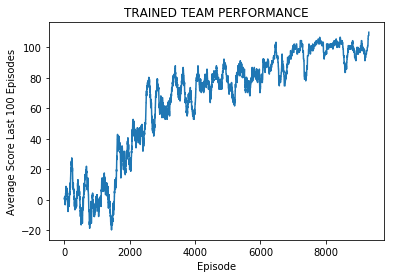

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rolling_average)+1), rolling_average)
plt.title('TRAINED TEAM PERFORMANCE')
plt.ylabel('Average Score Last 100 Episodes')
plt.xlabel('Episode')
plt.show()

Policy loss for striker and goalie. It should stay in the range of (-1,1). Value loss and entropy should decline over time.

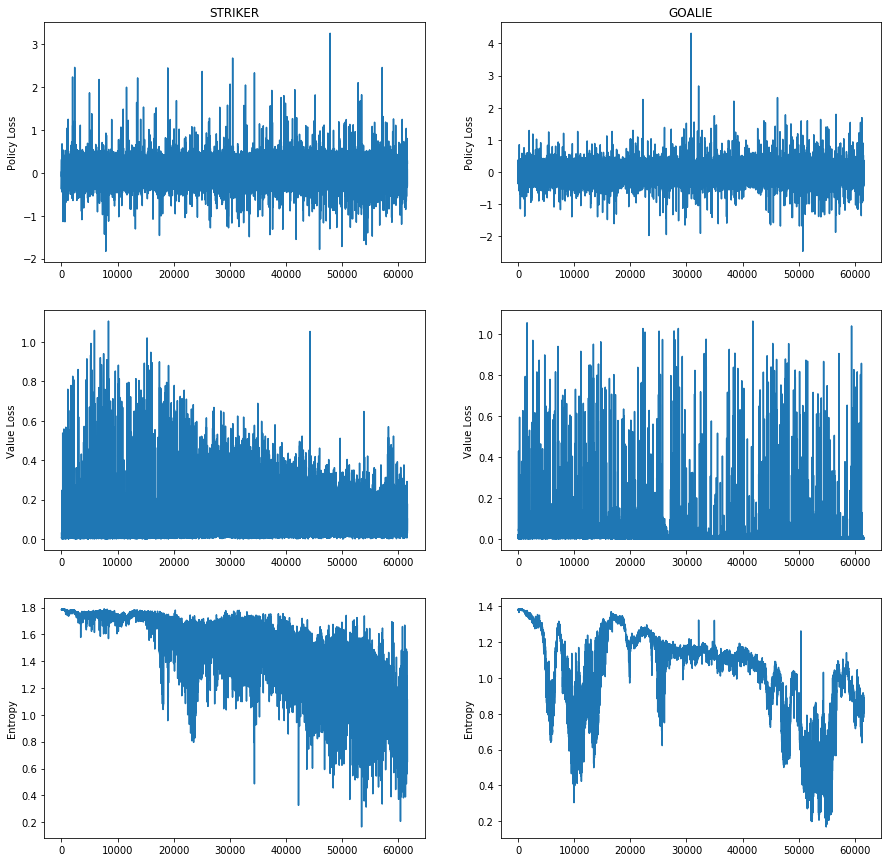

In [9]:
plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.plot(np.arange(1, len(policy_loss_value)+1), policy_loss_value)
plt.title('STRIKER')
plt.ylabel('Policy Loss')

plt.subplot(3,2,2)
plt.plot(np.arange(1, len(policy_loss_value_g)+1), policy_loss_value_g)
plt.title('GOALIE')
plt.ylabel('Policy Loss')

plt.subplot(3,2,3)
plt.plot(np.arange(1, len(value_loss_value)+1), value_loss_value)
plt.ylabel('Value Loss')

plt.subplot(3,2,4)
plt.plot(np.arange(1, len(value_loss_value_g)+1), value_loss_value_g)
plt.ylabel('Value Loss')

plt.subplot(3,2,5)
plt.plot(np.arange(1, len(entropy_value)+1), entropy_value)
plt.ylabel('Entropy')

plt.subplot(3,2,6)
plt.plot(np.arange(1, len(entropy_value_g)+1), entropy_value_g)
plt.ylabel('Entropy')

plt.show()

### 8. Watch The Trained Agents

The below code will load the trained actors (stiker and goalie) and run 100 games. A well trained team should win nearly all 100 games with a total score near 110. The other team is taking random actions.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

striker_0_actor = Actor(s_state_size, s_action_size, hidden_0, hidden_1).to(device)
goalie_0_actor = Actor(g_state_size, g_action_size, hidden_0, hidden_1).to(device)

# Load the saved training parameters
striker_0_actor.load_state_dict(torch.load('checkpoint_striker_0_actor.pth', map_location='cpu'))
goalie_0_actor.load_state_dict(torch.load('checkpoint_goalie_0_actor.pth', map_location='cpu'))

# Set environment to evalulation mode
env_info = env.reset(train_mode=False)        
g_states = env_info[g_brain_name].vector_observations  
s_states = env_info[s_brain_name].vector_observations  

team_0_score = 0
team_1_score = 0
team_0_delta = 0
team_0_lead = []

print("*** Starting the first game ***")

for i in range(100):

    g_scores = np.zeros(num_g_agents)                      
    s_scores = np.zeros(num_s_agents)           

    while True:
        states_all = combine_states(g_states, s_states)
        g0_prob, g0_action = act(goalie_0_actor, g_states[0])
        s0_prob, s0_action = act(striker_0_actor, s_states[0])
        g_actions = np.array([g0_action, np.random.choice(g_action_size)])
        s_actions = np.array([s0_action, np.random.choice(s_action_size)])
        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))
        env_info = env.step(actions)                       

        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations

        done = np.any(env_info[g_brain_name].local_done)  
        
        #update scores
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        g_scores += g_rewards
        s_scores += s_rewards

        # exit loop if episode finished
        if done:                                           
            break

        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
    
    # calculate team scores and team 0 lead
    team_0_score = round(g_scores[0] + s_scores[0], 2)
    team_1_score = round(g_scores[1] + s_scores[1], 2)
    team_0_delta = round(team_0_score + team_0_delta, 2)
    team_0_lead.append(team_0_delta)
        
    print('Episode {}:\tTrained Team Score: {}      Cumulative Score: {}'.format(i+1, team_0_score, team_0_delta))

print("*** Last game finished ***")

*** Starting the first game ***
Episode 1:	Trained Team Score: 1.1      Cumulative Score: 1.1
Episode 2:	Trained Team Score: 1.1      Cumulative Score: 2.2
Episode 3:	Trained Team Score: 1.1      Cumulative Score: 3.3
Episode 4:	Trained Team Score: 1.1      Cumulative Score: 4.4
Episode 5:	Trained Team Score: 1.1      Cumulative Score: 5.5
Episode 6:	Trained Team Score: 1.1      Cumulative Score: 6.6
Episode 7:	Trained Team Score: 1.1      Cumulative Score: 7.7
Episode 8:	Trained Team Score: 1.1      Cumulative Score: 8.8
Episode 9:	Trained Team Score: 1.1      Cumulative Score: 9.9
Episode 10:	Trained Team Score: 0.0      Cumulative Score: 9.9
Episode 11:	Trained Team Score: 1.1      Cumulative Score: 11.0
Episode 12:	Trained Team Score: 1.1      Cumulative Score: 12.1
Episode 13:	Trained Team Score: 1.1      Cumulative Score: 13.2
Episode 14:	Trained Team Score: 1.1      Cumulative Score: 14.3
Episode 15:	Trained Team Score: 1.1      Cumulative Score: 15.4
Episode 16:	Trained Team Sc

When finished, you can close the environment.

In [ ]:
env.close()